### Resting State EEG: entropy and complexity features
Time series analysis of resting state EEG signal using various entropy and complexity measures.

In [1]:
# Import packages
import os, mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk

# Set default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import signal_processing.spectral_analysis as spectr
import basic.arrange_data as arrange

Define these variables!

In [2]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results
results_foldername = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'OKTOS/Eyes Closed/Baseline'
exp_condition = 'EC_00'

# Power spectra estimation parameters
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=3)

Run this to set the folders for data.

In [36]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'_clean-epo.fif')

Files in Data/Clean/OKTOS/Eyes Closed/Baseline read in: 1


Study we are replicating:
- https://www.nature.com/articles/s41386-023-01586-4#Sec19

Lempel-Ziv Compexity (LZC)
- https://neuropsychology.github.io/NeuroKit/functions/complexity.html#neurokit2.complexity.complexity_lempelziv
- Lempel, A., & Ziv, J. (1976). On the complexity of finite sequences. IEEE Transactions on information theory, 22(1), 75-81. https://doi.org/10.1109/TIT.1976.1055501
- Zhang, Y., Hao, J., Zhou, C., & Chang, K. (2009). Normalized Lempel-Ziv complexity and its application in bio-sequence analysis. Journal of mathematical chemistry, 46(4), 1203-1212. https://doi.org/10.1007/s10910-008-9512-2

Multiscale Sample Entropy (MSE)
- https://neuropsychology.github.io/NeuroKit/functions/complexity.html#entropy-multiscale

"Due to the sensitivity of sample entropy to signal length we computed MSE on non-overlapping 4 s epochs and averaged across the epochs to achieve the ﬁnal MSE estimate [50]. MSE was estimated using 20 scale factors, m of 2, and r of 0.5."

In [121]:
# Loop through all the subjects' directories (EEG files directories)
df = pd.DataFrame(index=subject_names)
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    print('\n{} in progress:'.format(subject_names[i]))
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)
    
    # Resample the data to 256 Hz & convert to dataframe
    epochs = epochs.resample(sfreq=256)
    df_epochs = epochs.to_data_frame()
    
    ### Lempel-Ziv complexity

    # Go through all the channels signals
    lzc_i = []
    for ch in epochs.info['ch_names']:
        # Go through all epochs in the current channel signal
        lzc_ch = []
        for epo in df_epochs['epoch'].unique():
            # Calculate Lempel-Ziv Complexity (LZC) for the current epoch
            epo_signal = df_epochs[df_epochs['epoch']==epo][ch]
            lzc_epo, info = nk.complexity_lempelziv(epo_signal, symbolize='median')
            lzc_ch.append(lzc_epo)
        # Average all epochs' LZC values to get a single value for the channel & add to list
        lzc_i.append(np.mean(lzc_ch))
    # Average all the channels' LZC values to get a single value for the subject & add to master dataframe
    lzc_i_mean = np.mean(lzc_i)
    df.loc[subject_names[i], 'LZC'] = lzc_i_mean
    
    


OKTOS_0002_00A_EC in progress:


In [124]:
len(epo_signal)

1280

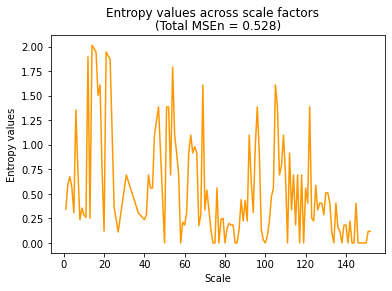

In [125]:
signal = nk.signal_simulate(duration=2, frequency=[5, 12, 40])

msen, info = nk.entropy_multiscale(signal, show=True)

dimension (m) : default is 3, paper uses 2
tolerance (r) : default is 0.2*signal std, paper uses 0.5

In [133]:
# MSE
for epo in df_epochs['epoch'].unique():
    epo_signal = df_epochs[df_epochs['epoch']==epo]['Fp1']
    msen, info = nk.entropy_multiscale(epo_signal.to_numpy(), scale=20, dimension=2, tolerance=0.5, show=False)

In [173]:
np.zeros(shape=(len(subject_names),1))

array([[0.]])

In [177]:
np.mean([mse_vals_ch, mse_vals_ch], axis=0)

/Users/tanijarv/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


array([[0.59993558, 0.89081949, 0.90980071, ..., 1.15129255, 0.91913974,
        1.47221949],
       [0.57326826, 0.91640371, 0.95135218, ..., 0.94353482, 1.03972077,
        0.78430796],
       [0.58575034, 0.88250237, 0.91713036, ..., 1.12035484, 0.72345949,
        0.70438361],
       ...,
       [0.63847306, 0.97253596, 1.04541736, ..., 0.79206005, 0.95846131,
        1.15129255],
       [0.63679899, 0.95667395, 1.0389935 , ..., 1.22117352, 1.47221949,
        1.03972077],
       [0.63006913, 0.97819896, 1.02265025, ..., 0.61188772, 1.00745151,
        1.15129255]])

In [207]:
# Go through all the channels signals
mse_i = []
mse_vals_i = np.zeros(shape=(len(subject_names),1))
for ch in epochs.info['ch_names']:
    # Go through all epochs in the current channel signal
    mse_ch = []
    mse_vals_epo = []
    for epo in df_epochs['epoch'].unique():
        # Calculate Multiscale Sample Entropy (MSE) measures for the current epoch
        epo_signal = df_epochs[df_epochs['epoch']==epo][ch]

        mse_epo, info = nk.entropy_multiscale(epo_signal.to_numpy(), scale=20, dimension=2, show=False)
        mse_ch.append(mse_epo)
        # Get the scales' MSE values for the current epoch & add to list including all epochs
        mse_vals_epo.append(info.get('Value'))
    # Average all epochs' MSE values to get an array with a length of scale for the current channel
    mse_vals_ch = np.mean(mse_vals_epo, axis=0)

    # Average all epochs' MSE totals to get a single value for the channel & add to list
    mse_i.append(np.mean(mse_ch))
# Average all the channels' MSE totals to get a single value for the subject & add to master dataframe
mse_i_mean = np.mean(mse_i)

# to-do: need to merge all channels' mse_vals_ch arrays together for the subject and then average by element (to get still 20 values)

#df.loc[subject_names[i], 'LZC'] = lzc_i_mean

In [215]:
np.mean(mse_vals_epo, axis=0)

array([0.94860554, 1.52775439, 1.63773744, 1.69104945, 1.74580714,
       1.75448656, 1.78781325, 1.82385006, 1.81083354, 1.81076153,
       1.77435627, 1.76783533, 1.76622991, 1.79078655, 1.81706553,
       1.74938909, 1.753274  , 1.77124044, 1.64682871, 1.71249647])

In [196]:
mse_epo

1.708037756114452

In [197]:
mse_vals_epo

[array([1.01463746, 1.55075441, 1.61722871, 1.70741832, 1.79486989,
        1.7591833 , 1.83258146, 1.7602608 , 1.56339397, 1.72506809,
        2.26336438, 1.76098781, 1.94591015, 2.04122033, 1.91692261,
        1.88706965, 1.96360973, 2.00533357, 1.92789164, 1.79175947]),
 array([0.85489436, 1.41864432, 1.54200795, 1.56943258, 1.90768894,
        2.00148   , 2.05675013, 1.87691728, 1.9824996 , 1.84582669,
        1.64865863, 1.79175947, 1.85629799, 1.9095425 , 2.13350876,
        1.78058617, 1.88706965, 1.71171676, 1.58240924, 1.64865863]),
 array([1.0902403 , 1.67889264, 1.71184226, 1.78621929, 1.75949861,
        1.75163948, 1.85735675, 1.8845412 , 1.55200586, 1.54756251,
        1.67397643, 1.98482557, 1.83067489, 1.4147323 , 1.94591015,
        1.60943791, 1.46228027, 1.9980959 , 1.36948724, 1.44238383]),
 array([1.06535558, 1.64029839, 1.6981769 , 1.71266022, 1.57993725,
        1.72313096, 1.50648994, 1.7849335 , 1.55931353, 1.95210212,
        1.93874166, 2.04553999, 1.76509122

In [187]:
len(np.mean(mse_vals_epo, axis=0))

20

In [180]:
mse_vals_ch

array([[1.19987117, 1.78163899, 1.81960141, 1.90848374, 2.06462646,
        2.07944154, 1.97408103, 2.10006083, 1.93075834, 1.89974811,
        2.65324196, 1.94591015, 1.94591015, 2.46385324, 2.42036813,
        2.05412373, 2.42774824, 2.30258509, 1.83827948, 2.94443898],
       [1.14653652, 1.83280743, 1.90270436, 2.05510944, 2.22462355,
        2.16754881, 3.4339872 , 2.74727091, 2.18323834, 3.23867845,
        2.32238772, 2.32727771, 2.01490302, 2.27726729, 3.61091791,
        2.36712361, 2.1690537 , 1.88706965, 2.07944154, 1.56861592],
       [1.17150067, 1.76500473, 1.83426073, 1.83480122, 1.79010794,
        1.90834705, 1.99567166, 1.88413279, 1.8115621 , 1.67843078,
        1.57818537, 1.99243016, 1.99243016, 1.77978328, 2.1690537 ,
        1.70474809, 1.46151778, 2.24070969, 1.44691898, 1.40876722],
       [1.17374929, 1.78974595, 1.84606163, 1.8117955 , 1.69167601,
        1.91142397, 1.63141682, 1.95964034, 1.57455065, 2.29486305,
        2.39789527, 1.98100147, 2.05412373, 2

(2.1217444138253265,
 {'Method': 'MSEn',
  'Algorithm': 'entropy_sample',
  'Coarsegraining': 'nonoverlapping',
  'Dimension': 2,
  'Scale': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20]),
  'Tolerance': 0.5,
  'Value': array([1.26013826, 1.95639792, 2.0453005 , 2.21226245, 2.16102153,
         2.27441422, 2.34180581, 2.62466859, 2.7080502 , 2.48490665,
         2.14006616, 2.21920348, 3.09104245, 2.7080502 , 2.15948425,
         1.84582669, 2.44234704, 1.22377543, 2.01490302, 2.30258509])})

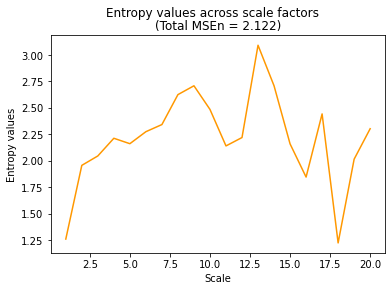

In [159]:
nk.entropy_multiscale(epo_signal.to_numpy(), scale=20, dimension=2, tolerance=0.5, show=True)

In [158]:
mse_epo

2.1217444138253265

In [163]:
info.get('Value')

array([1.26013826, 1.95639792, 2.0453005 , 2.21226245, 2.16102153,
       2.27441422, 2.34180581, 2.62466859, 2.7080502 , 2.48490665,
       2.14006616, 2.21920348, 3.09104245, 2.7080502 , 2.15948425,
       1.84582669, 2.44234704, 1.22377543, 2.01490302, 2.30258509])

In [139]:
nk.entropy_multiscale(epo_signal.to_numpy(), scale=20, dimension=2, tolerance=0.5, show=False)

(2.1217444138253265,
 {'Method': 'MSEn',
  'Algorithm': 'entropy_sample',
  'Coarsegraining': 'nonoverlapping',
  'Dimension': 2,
  'Scale': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20]),
  'Tolerance': 0.5,
  'Value': array([1.26013826, 1.95639792, 2.0453005 , 2.21226245, 2.16102153,
         2.27441422, 2.34180581, 2.62466859, 2.7080502 , 2.48490665,
         2.14006616, 2.21920348, 3.09104245, 2.7080502 , 2.15948425,
         1.84582669, 2.44234704, 1.22377543, 2.01490302, 2.30258509])})

In [136]:
mse_i

[1.9018074724075438,
 1.7902318297657862,
 2.2058752323380655,
 1.964635209638265,
 1.9179275915485356,
 2.071543637613099,
 2.4184251334329074,
 1.8636476817115353,
 1.825247252692133,
 2.106325979183569,
 2.311033003065078,
 1.698273648533519,
 1.7963757169552614,
 1.9278962734109966,
 2.0188637953444095,
 1.9290839014594894,
 2.097720579781111,
 1.9040838789132573,
 2.0751155236540857,
 2.139376413432343,
 2.14880230994495,
 1.9310870377476987,
 2.215120990170602,
 2.4606982662663195,
 2.300761949357266,
 2.0701003773606783,
 2.065820101135551,
 2.3830955786471932,
 1.6734950085858409,
 2.2138751708465594,
 1.9730395246508854,
 1.959891863128791]

In [135]:
mse_i_mean

2.042477435397604